In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph

# colormap
cmap = plt.get_cmap('plasma')

# Planning:
- get test examples to run, handle ind point limitations
- get real world dataset example to run

### BUGS:

- nans occur for too many ind points (in exp gradient)
- m and S values go to infinity if inducing_point_res >= 9

(solved?)

- implemented logdet for kl div, added stabilizer


### TODOS:
- clean code into functions
- Check T region definition (currently limits of inducing points)
- Add inducing point location optimization

- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

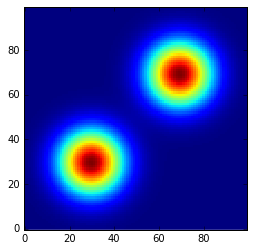

In [3]:
res = 100
Tlims = np.array([[0., 10.], [0., 10.]])

X = build_2d_grid(Tlims, res)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='none', origin='lower')
plt.show()

In [4]:
samples, _, _, _, _, _ = get_scp_samples(double_blob, Tlims, 10)

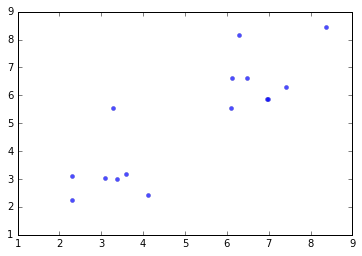

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

#### Evaluation with learned alphas and increasing number of inducing points

In [6]:
## ######## ##
# PARAMETERS #
## ######## ##
train_hyperparameters    = False
optimize_inducing_points = True
ind_point_nums           = [2, 4]

eval_res = 100

# build_evaluation_grid
eval_grid = build_2d_grid(Tlims, eval_res)

for n_ind, i in enumerate(ind_point_nums): 
    
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, Tlims, optimize_inducing_points=optimize_inducing_points, train_hyperparameters=train_hyperparameters)
    lam_vals = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

    #plots
    fig = plt.figure(figsize=(15, 5)) 
    max_value = np.max([np.max(vals), np.max(lam_vals)])
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

    print("ind point number: ",i)
    print("alphas: ",alphas_opt)
    print("gamma: ",gamma_opt)
    
    xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))
    
    ax0 = plt.subplot(1,2,1)
    im = ax0.pcolormesh(xx, yy, lam_vals.reshape(eval_res,eval_res), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('prediciton with samples')
    ax0.scatter(samples[:,0], samples[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])

    ax1 = plt.subplot(1,2, 2)
    im1 = ax1.pcolormesh(xx, yy, vals, cmap=cmap,norm=norm)
    fig.colorbar(im1, ax=ax1)
    ax1.set_title('groundtruth with inducing points')
    ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
    plt.xlim(Tlims[0,0], Tlims[0,1])
    plt.ylim(Tlims[1,0], Tlims[1,1])
    #plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
    plt.show()

Begin training


InvalidArgumentError: optimization/gradients/integration-over-region-T/psi_matrix/Pow_grad/Log:0 : Tensor had Inf and NaN values
	 [[Node: nanchecks/CheckNumerics_639 = CheckNumerics[T=DT_FLOAT, message="optimization/gradients/integration-over-region-T/psi_matrix/Pow_grad/Log:0", _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/gradients/ard_kernel/pow_grad/Log, ^nanchecks/CheckNumerics_638)]]

Caused by op 'nanchecks/CheckNumerics_639', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-085f29310749>", line 15, in <module>
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, Tlims, optimize_inducing_points=optimize_inducing_points, train_hyperparameters=train_hyperparameters)
  File "/home/max/Uni/17_18_WiSe/PMAI/pmai-vi-gpmpp/utils.py", line 63, in train_parameters
    check = tf.add_check_numerics_ops()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/numerics.py", line 81, in add_check_numerics_ops
    check_op = [array_ops.check_numerics(output, message=message)]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 569, in check_numerics
    "CheckNumerics", tensor=tensor, message=message, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): optimization/gradients/integration-over-region-T/psi_matrix/Pow_grad/Log:0 : Tensor had Inf and NaN values
	 [[Node: nanchecks/CheckNumerics_639 = CheckNumerics[T=DT_FLOAT, message="optimization/gradients/integration-over-region-T/psi_matrix/Pow_grad/Log:0", _device="/job:localhost/replica:0/task:0/device:CPU:0"](optimization/gradients/ard_kernel/pow_grad/Log, ^nanchecks/CheckNumerics_638)]]
